In [7]:
%pip install pandas --break-system-packages
import pandas as pd
df= pd.read_csv("news.csv")
sentiment_mapping = {"neutral": 0, "positive": 1, "negative": 2}
df['sentiment'] = df['sentiment'].map(sentiment_mapping)
df.describe()

Note: you may need to restart the kernel to use updated packages.


sentiment
count  4846.000000
mean      0.530541
std       0.706008
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       2.000000

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


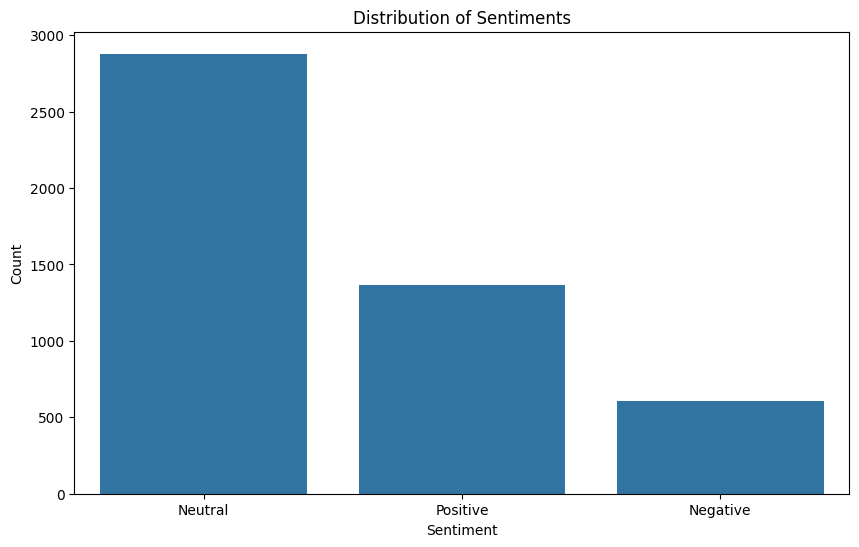

In [8]:
%pip install matplotlib seaborn --break-system-packages
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=df, legend=False)
plt.title('Distribution of Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks([0, 1, 2], ['Neutral', 'Positive', 'Negative'])
plt.show()

In [9]:

def text_clean(text: str) -> str:
    import re
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.strip()
    return text
df['message'] = df['message'].apply(text_clean)
df["message"].head(5)

0    according to gran  the company has no plans to...
1    technopolis plans to develop in stages an area...
2    the international electronic industry company ...
3    with the new production plant the company woul...
4    according to the company s updated strategy fo...
Name: message, dtype: object

In [10]:

from nltk.corpus import stopwords
def remove_stopwords(text: str) -> str:
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_text = ' '.join([word for word in words if word not in stop_words])
    return filtered_text
df['message'] = df['message'].apply(remove_stopwords)
df

sentiment                                            message
0             0  according gran company plans move production r...
1             0  technopolis plans develop stages area less squ...
2             2  international electronic industry company elco...
3             1  new production plant company would increase ca...
4             1  according company updated strategy years baswa...
...         ...                                                ...
4841          2  london marketwatch share prices ended lower lo...
4842          0  rinkuskiai beer sales fell per cent million li...
4843          2  operating profit fell eur mn eur mn including ...
4844          2  net sales paper segment decreased eur mn secon...
4845          2  sales finland decreased january sales outside ...

[4846 rows x 2 columns]

**WORD TO VECTOR**


word to vector is a technique used in natural language processing (NLP) to represent words as numerical vectors in a continuous vector space. This representation allows for the capture of semantic relationships between words, enabling various NLP tasks such as text classification, sentiment analysis, and machine translation.

In [18]:
from gensim.models import Word2Vec

sentences = [row.split() for row in df['message']]
d2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
d2v_model.save("word2vec.model")

**TRAINING DATA PREPARATION**

In [21]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['message'], df['sentiment'], test_size=0.2, random_state=42)
import numpy as np
def vectorizer(text: str) -> np.ndarray:
    words = text.split()
    vector = np.zeros(100)
    for word in words:
        if word in d2v_model.wv:
            vector += d2v_model.wv[word]
    return vector
X_train_vectors = np.array([vectorizer(text) for text in X_train])
X_test_vectors = np.array([vectorizer(text) for text in X_test])


In [22]:
X_train_vectors.shape, X_test_vectors.shape

((3876, 100), (970, 100))

In [ ]:
X_train.tolist()

['russia raisio food division home market stretches way vladivostok',
 'operators need learn use one device multiple levels applications including voicedirected operations',
 'company expects net sales first half reach previous year level',
 'bridge km long located anasmotet road e new traffic junction marieholm road e',
 'nokia capcom announced resident evil degeneration released ngage later year',
 'time delighted fact able accomplish organization team members',
 'launch new g handsets nokia aims become winner china g market g market',
 'chf great product',
 'eps continuing operations came eur',
 'earnings per share eps first quarter amounted loss eur',
 'january finnish flag carrier finnair oyj hel fias said today sealed nineyear sale leaseback agreement newest airbus aircraft syndication japanese operating lease market',
 'company expects net sales significantly increase',
 'sales clothing developed best',
 'ruukki signed contract norwegian company veidekke entreprenor',
 'net loss

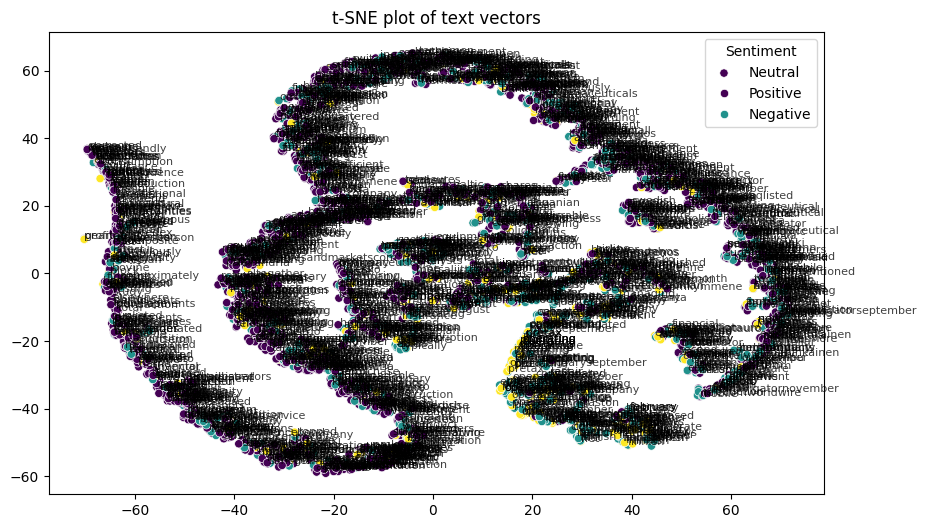

In [40]:
from sklearn.manifold import TSNE

# Combine train and test vectors for visualization
all_vectors = np.concatenate((X_train_vectors, X_test_vectors), axis=0)
all_labels = np.concatenate((y_train, y_test), axis=0)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(all_vectors)

# Plotting
plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=all_labels, palette="viridis", legend="full")
try:
  for i, word in enumerate(X_train.tolist()):
        plt.annotate(word.split()[0], (tsne_results[i, 0], tsne_results[i, 1]), fontsize=8, alpha=0.75)
except:
    pass        
        
plt.title('t-SNE plot of text vectors')
plt.legend(title='Sentiment', loc='best', labels=['Neutral', 'Positive', 'Negative'])
plt.show()

In [30]:
import torch.nn as nn
import torch.optim as optim
import torch

setiment_classifier= nn.Sequential(
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 3)
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(setiment_classifier.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
setiment_classifier.to(device)
X_train_tensor = torch.tensor(X_train_vectors, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)
num_epochs = 100000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = setiment_classifier(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    

Epoch [1/100000], Loss: 1.1901
Epoch [2/100000], Loss: 1.0716
Epoch [3/100000], Loss: 1.0015
Epoch [4/100000], Loss: 0.9761
Epoch [5/100000], Loss: 0.9728
Epoch [6/100000], Loss: 0.9746
Epoch [7/100000], Loss: 0.9726
Epoch [8/100000], Loss: 0.9644
Epoch [9/100000], Loss: 0.9519
Epoch [10/100000], Loss: 0.9390
Epoch [11/100000], Loss: 0.9292
Epoch [12/100000], Loss: 0.9247
Epoch [13/100000], Loss: 0.9244
Epoch [14/100000], Loss: 0.9259
Epoch [15/100000], Loss: 0.9265
Epoch [16/100000], Loss: 0.9255
Epoch [17/100000], Loss: 0.9233
Epoch [18/100000], Loss: 0.9208
Epoch [19/100000], Loss: 0.9188
Epoch [20/100000], Loss: 0.9177
Epoch [21/100000], Loss: 0.9175
Epoch [22/100000], Loss: 0.9179
Epoch [23/100000], Loss: 0.9182
Epoch [24/100000], Loss: 0.9179
Epoch [25/100000], Loss: 0.9169
Epoch [26/100000], Loss: 0.9151
Epoch [27/100000], Loss: 0.9131
Epoch [28/100000], Loss: 0.9114
Epoch [29/100000], Loss: 0.9103
Epoch [30/100000], Loss: 0.9097
Epoch [31/100000], Loss: 0.9094
Epoch [32/100000]

In [32]:
setiment_classifier.eval()
X_test_tensor = torch.tensor(X_test_vectors, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)
with torch.no_grad():
    outputs = setiment_classifier(X_test_tensor)
    _, predicted = torch.max(outputs.data, 1)
    correct = (predicted == y_test_tensor).sum().item()
    accuracy = correct / y_test_tensor.size(0)
    print(f'Accuracy of the model on the test set: {accuracy:.4f}')

Accuracy of the model on the test set: 0.6340


In [33]:
from sklearn.metrics import classification_report
print(classification_report(y_test_tensor.cpu(), predicted.cpu(), target_names=['Neutral', 'Positive', 'Negative']))
import pickle
with open('model1.pkl', 'wb') as f:
    pickle.dump(setiment_classifier, f)
    
    

              precision    recall  f1-score   support

     Neutral       0.70      0.85      0.77       571
    Positive       0.54      0.33      0.41       289
    Negative       0.35      0.32      0.33       110

    accuracy                           0.63       970
   macro avg       0.53      0.50      0.50       970
weighted avg       0.61      0.63      0.61       970



In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)

# Fit and transform the training data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray()

# Transform the test data
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray()
# Train the model
logreg.fit(X_train_vectors, y_train)

# Predict on the test set
y_pred = logreg.predict(X_test_vectors)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

# Print classification report
print(classification_report(y_test, y_pred, target_names=['Neutral', 'Positive', 'Negative']))

Accuracy: 0.6753
              precision    recall  f1-score   support

     Neutral       0.68      0.97      0.80       571
    Positive       0.65      0.30      0.41       289
    Negative       0.77      0.15      0.26       110

    accuracy                           0.68       970
   macro avg       0.70      0.47      0.49       970
weighted avg       0.68      0.68      0.62       970



In [36]:
pickle.dump(logreg, open('model2.pkl', 'wb'))